In [1]:
import sys
from pathlib import Path
# Get the repository root (1 levels up from current notebook)
repo_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, trustworthiness
import Template
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

Template = Template.Template()

# Build the path to the Excel file in the repository root
data_path = os.path.join(repo_root, 'Datos1_InteraccionesNIR.xlsx')

# Accuracy

Checking path: c:\Users\ricar\Documents\GitHub\DiPreSi\Modelos\Modelo 1\model1_accuracies.csv
  File exists: True
  CSV files in Modelo 1: ['model1_accuracies.csv', 'model1_f1_scores.csv', 'predictions.csv', 'test_sample_df.csv']
✓ Loaded model1_accuracies.csv - Shape: (15, 2)
  Columns: ['Model', 'Accuracy']
  Head:
   Model  Accuracy
0      1  0.810753
1      2  0.821505
2      3  0.840860
3      4  0.539785
4      5  0.741935

Checking path: c:\Users\ricar\Documents\GitHub\DiPreSi\Modelos\Modelo 2\model2_accuracies.csv
  File exists: True
  CSV files in Modelo 2: ['model2_accuracies.csv', 'model2_f1_scores.csv', 'predictions.csv', 'test_sample_df.csv']
✓ Loaded model2_accuracies.csv - Shape: (15, 2)
  Columns: ['Model', 'Accuracy']
  Head:
   Model  Accuracy
0      1  0.618952
1      2  0.814516
2      3  0.812500
3      4  0.614919
4      5  0.756048

Checking path: c:\Users\ricar\Documents\GitHub\DiPreSi\Modelos\Modelo 3\model3_accuracies.csv
  File exists: True
  CSV files in Mod

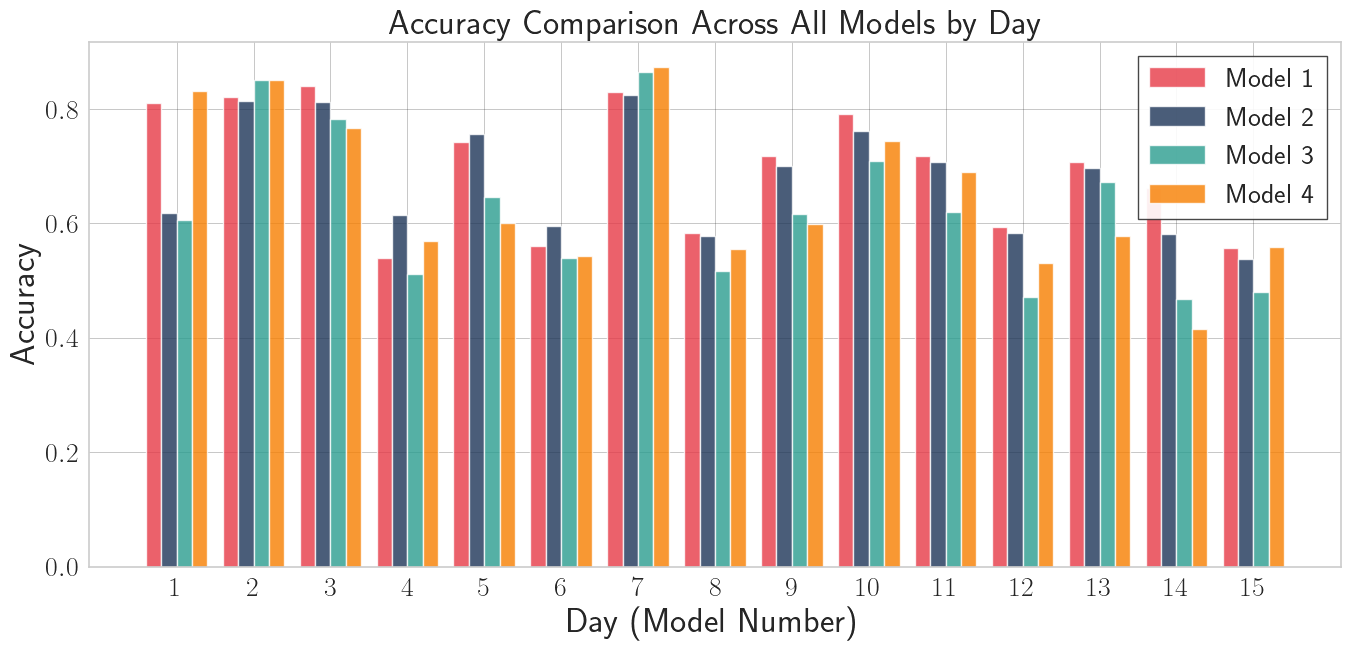

In [2]:
# Import all model accuracies from CSV files
import os
from pathlib import Path

# Define the model folders
model_folders = ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4']

# Dictionary to store dataframes
accuracies = {}

# Load each model's accuracy CSV
for i, folder in enumerate(model_folders, start=1):
    csv_path = os.path.join(repo_root, 'Modelos', folder, f'model{i}_accuracies.csv')
    
    # Debug: Print the full path being checked
    print(f"Checking path: {csv_path}")
    print(f"  File exists: {os.path.exists(csv_path)}")
    
    # If file doesn't exist, check what files ARE in the folder
    folder_path = os.path.join(repo_root, 'Modelos', folder)
    if os.path.exists(folder_path):
        files_in_folder = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
        print(f"  CSV files in {folder}: {files_in_folder}")
    
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        accuracies[f'model{i}'] = df
        print(f"✓ Loaded model{i}_accuracies.csv - Shape: {df.shape}")
        print(f"  Columns: {df.columns.tolist()}")
        print(f"  Head:\n{df.head()}\n")
    else:
        print(f"✗ Warning: {csv_path} not found!\n")

# Access individual dataframes
df_model1_acc = accuracies.get('model1')
df_model2_acc = accuracies.get('model2')
df_model3_acc = accuracies.get('model3')
df_model4_acc = accuracies.get('model4')

# Combine all accuracies into one dataframe for comparison
if all(key in accuracies for key in ['model1', 'model2', 'model3', 'model4']):
    # Merge dataframes
    combined_accuracies = df_model1_acc.copy()
    combined_accuracies.rename(columns={'Accuracy': 'Model1_Accuracy'}, inplace=True)
    
    combined_accuracies['Model2_Accuracy'] = df_model2_acc['Accuracy'].values
    combined_accuracies['Model3_Accuracy'] = df_model3_acc['Accuracy'].values
    combined_accuracies['Model4_Accuracy'] = df_model4_acc['Accuracy'].values
    
    print("Combined accuracies:")
    print(combined_accuracies)
    
    # Visualize comparison
    plt.figure(figsize=(14, 7))
    x = combined_accuracies['Model'].values
    width = 0.2
    
    plt.bar(x - 1.5*width, combined_accuracies['Model1_Accuracy'], width, label='Model 1', alpha=0.8)
    plt.bar(x - 0.5*width, combined_accuracies['Model2_Accuracy'], width, label='Model 2', alpha=0.8)
    plt.bar(x + 0.5*width, combined_accuracies['Model3_Accuracy'], width, label='Model 3', alpha=0.8)
    plt.bar(x + 1.5*width, combined_accuracies['Model4_Accuracy'], width, label='Model 4', alpha=0.8)
    
    plt.xlabel('Day (Model Number)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison Across All Models by Day')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(x)
    plt.tight_layout()
    plt.show()
else:
    print("Warning: Not all model accuracy files were loaded!")
    print(f"Loaded models: {list(accuracies.keys())}")
    missing_models = [f'model{i}' for i in range(1, 5) if f'model{i}' not in accuracies]
    print(f"Missing models: {missing_models}")

<>:43: SyntaxWarning: invalid escape sequence '\%'
<>:43: SyntaxWarning: invalid escape sequence '\%'
C:\Users\ricar\AppData\Local\Temp\ipykernel_7340\2370525425.py:43: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Accuracy (\%)', fontsize=24, fontweight='bold')


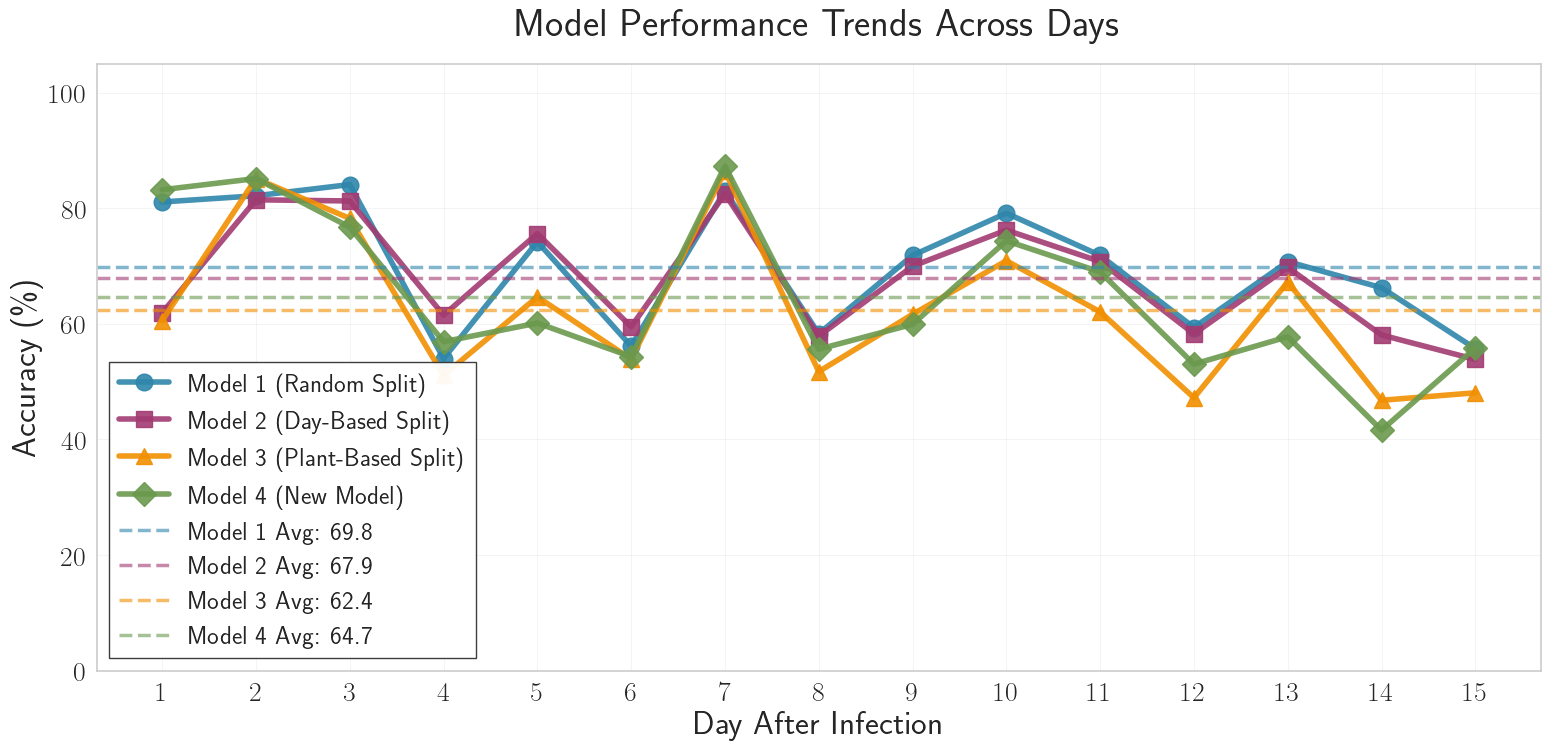

In [ ]:
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# ============================================================================
# PLOT 1: Line Plot with Confidence Bands (Trend Over Days)
# ============================================================================
plt.figure(figsize=(16, 8))

days = combined_accuracies['Model'].values

# Convert accuracies to percentage (0-100)
model1_pct = combined_accuracies['Model1_Accuracy'] * 100
model2_pct = combined_accuracies['Model2_Accuracy'] * 100
model3_pct = combined_accuracies['Model3_Accuracy'] * 100
model4_pct = combined_accuracies['Model4_Accuracy'] * 100

# Plot lines with markers (removed fill_between for area under curve)
plt.plot(days, model1_pct, marker='o', linewidth=4, 
         markersize=12, label='Model 1 (SMOTE-PCA)', color='#2E86AB', alpha=0.9)
plt.plot(days, model2_pct, marker='s', linewidth=4, 
         markersize=12, label='Model 2 (PCA-SMOTE)', color='#A23B72', alpha=0.9)
plt.plot(days, model3_pct, marker='^', linewidth=4, 
         markersize=12, label='Model 3 (PCA-SMOTE-UniformSampling)', color='#F18F01', alpha=0.9)
plt.plot(days, model4_pct, marker='D', linewidth=4, 
         markersize=12, label='Model 4 (UMAP-SMOTE)', color='#6A994E', alpha=0.9)

# Add mean lines
plt.axhline(y=model1_pct.mean(), color='#2E86AB', 
            linestyle='--', linewidth=2.5, alpha=0.6, 
            label=f'Model 1 Avg: {model1_pct.mean():.1f}%')
plt.axhline(y=model2_pct.mean(), color='#A23B72', 
            linestyle='--', linewidth=2.5, alpha=0.6, 
            label=f'Model 2 Avg: {model2_pct.mean():.1f}%')
plt.axhline(y=model3_pct.mean(), color='#F18F01', 
            linestyle='--', linewidth=2.5, alpha=0.6, 
            label=f'Model 3 Avg: {model3_pct.mean():.1f}%')
plt.axhline(y=model4_pct.mean(), color='#6A994E', 
            linestyle='--', linewidth=2.5, alpha=0.6, 
            label=f'Model 4 Avg: {model4_pct.mean():.1f}%')

plt.xlabel('Day After Infection', fontsize=24, fontweight='bold')
plt.ylabel('Accuracy (\%)', fontsize=24, fontweight='bold')
plt.title('Model Performance Trends Across Days', fontsize=28, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=18, framealpha=0.95)
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.xticks(days, fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0, 105])
plt.tight_layout()
plt.show()

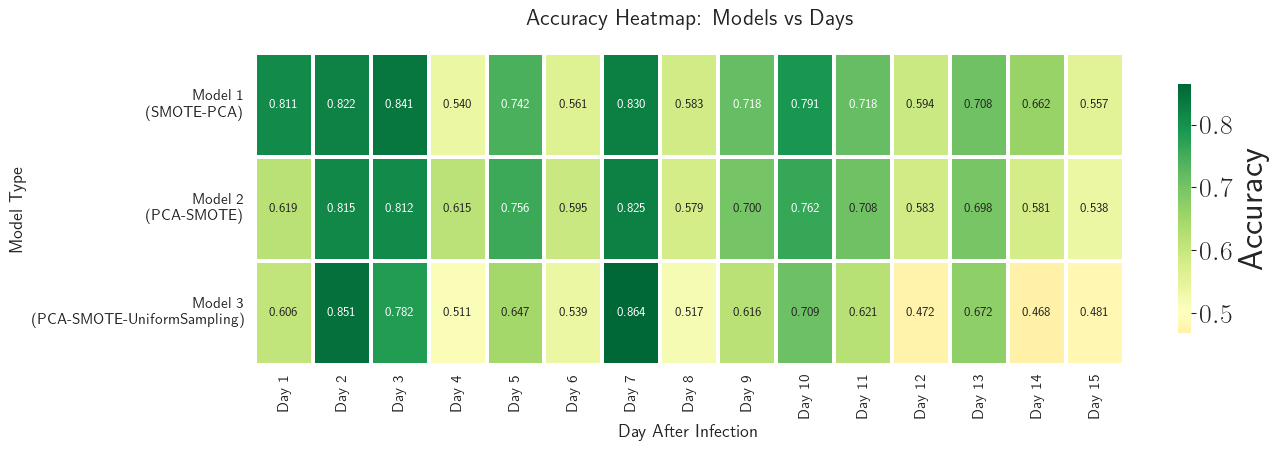

In [4]:
# ============================================================================
# PLOT 2: Heatmap with Annotations (Day-by-Model Matrix)
# ============================================================================
plt.figure(figsize=(14, 5))

# Prepare data for heatmap
heatmap_data = combined_accuracies[['Model1_Accuracy', 'Model2_Accuracy', 'Model3_Accuracy', 'Model4_Accuracy']].T
heatmap_data.columns = [f'Day {i}' for i in days]
heatmap_data.index = ['Model 1\n(SMOTE-PCA)', 'Model 2\n(PCA-SMOTE)', 'Model 3\n(PCA-SMOTE-UniformSampling)', 'Model 4\n(New Model)']

# Create heatmap with custom colormap
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5,
            cbar_kws={'label': 'Accuracy', 'shrink': 0.8},
            linewidths=1.5, linecolor='white',
            annot_kws={'size': 9, 'weight': 'bold'})

plt.title('Accuracy Heatmap: Models vs Days', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Day After Infection', fontsize=13, fontweight='bold')
plt.ylabel('Model Type', fontsize=13, fontweight='bold')
plt.yticks(rotation=0, fontsize=11)
plt.xticks(fontsize=11)
plt.tight_layout()
plt.show()

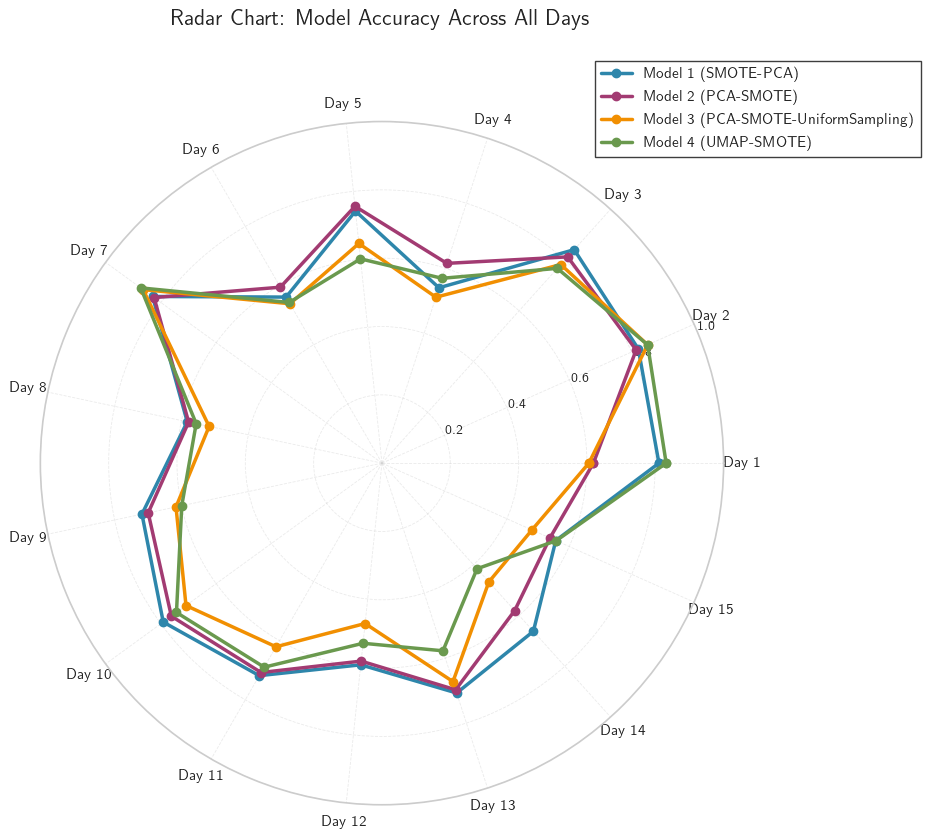

In [9]:
# ============================================================================
# PLOT 3: Radar/Spider Chart (Overall Performance Comparison)
# ============================================================================
from math import pi

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Prepare data
categories = [f'Day {i}' for i in days]
num_vars = len(categories)

# Compute angle for each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Complete the circle

# Plot data for each model
models_data = [
    (combined_accuracies['Model1_Accuracy'].values, 'Model 1 (SMOTE-PCA)', '#2E86AB'),
    (combined_accuracies['Model2_Accuracy'].values, 'Model 2 (PCA-SMOTE)', '#A23B72'),
    (combined_accuracies['Model3_Accuracy'].values, 'Model 3 (PCA-SMOTE-UniformSampling)', '#F18F01'),
    (combined_accuracies['Model4_Accuracy'].values, 'Model 4 (UMAP-SMOTE)', '#6A994E'), 
]

for data, label, color in models_data:
    values = data.tolist()
    values += values[:1]  # Complete the circle
    ax.plot(angles, values, 'o-', linewidth=2.5, label=label, color=color, markersize=6)

# Customize the plot
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax.grid(True, linestyle='--', alpha=0.4)

plt.title('Radar Chart: Model Accuracy Across All Days', 
          fontsize=16, fontweight='bold', pad=30, y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11, framealpha=0.95)
plt.tight_layout()
plt.show()

# F1-Score

Loaded model1_f1_scores.csv - Shape: (15, 2)
  Columns: ['Model', 'F1_Score']
  Head:
   Model  F1_Score
0      1  0.323077
1      2  0.144330
2      3  0.478873
3      4  0.331250
4      5  0.405941

Loaded model2_f1_scores.csv - Shape: (15, 2)
  Columns: ['Model', 'F1_Score']
  Head:
   Model  F1_Score
0      1  0.174672
1      2  0.132075
2      3  0.443114
3      4  0.369637
4      5  0.398010

Loaded model3_f1_scores.csv - Shape: (15, 2)
  Columns: ['Model', 'F1_Score']
  Head:
   Model  F1_Score
0      1  0.089552
1      2  0.103896
2      3  0.322148
3      4  0.260586
4      5  0.254545

Loaded model4_f1_scores.csv - Shape: (15, 2)
  Columns: ['Model', 'F1_Score']
  Head:
   Model  F1_Score
0      1  0.170213
1      2  0.103896
2      3  0.260274
3      4  0.242424
4      5  0.251012

Combined F1 scores:
    Model  Model1_F1  Model2_F1  Model3_F1  Model4_F1
0       1   0.323077   0.174672   0.089552   0.170213
1       2   0.144330   0.132075   0.103896   0.103896
2       3   0.

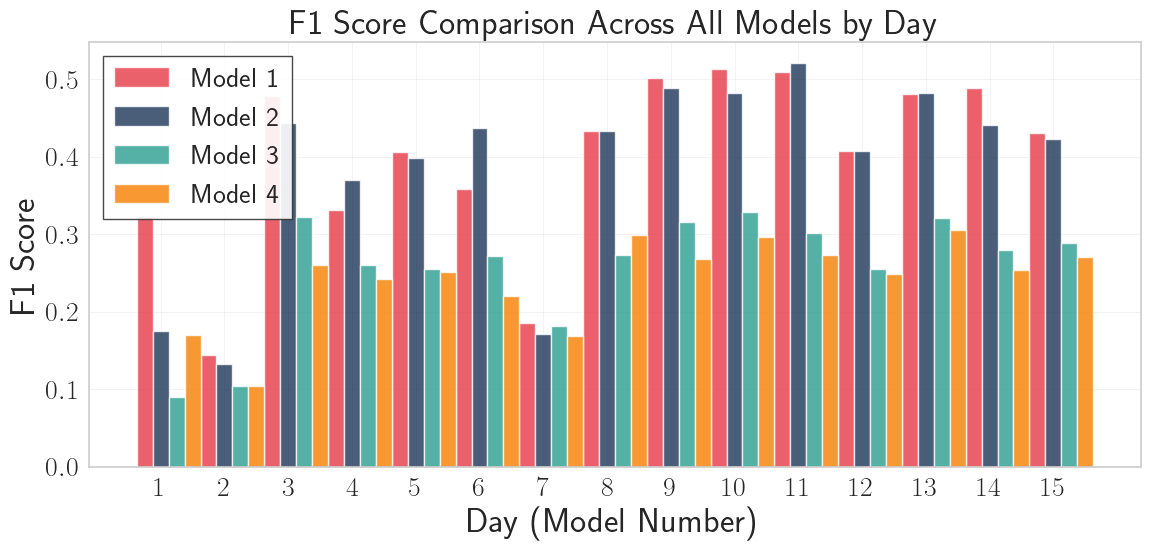

In [10]:
# Import all model F1 scores from CSV files
import os
from pathlib import Path

# Define the model folders
model_folders = ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4']

# Dictionary to store dataframes
f1_scores = {}

# Load each model's F1 score CSV
for i, folder in enumerate(model_folders, start=1):
    csv_path = os.path.join(repo_root, 'Modelos', folder, f'model{i}_f1_scores.csv')
    
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        f1_scores[f'model{i}'] = df
        print(f"Loaded model{i}_f1_scores.csv - Shape: {df.shape}")
        print(f"  Columns: {df.columns.tolist()}")
        print(f"  Head:\n{df.head()}\n")
    else:
        print(f"Warning: {csv_path} not found!\n")

# Access individual dataframes
df_model1_f1 = f1_scores.get('model1')
df_model2_f1 = f1_scores.get('model2')
df_model3_f1 = f1_scores.get('model3')
df_model4_f1 = f1_scores.get('model4')

# Combine all F1 scores into one dataframe for comparison
if all(key in f1_scores for key in ['model1', 'model2', 'model3', 'model4']):
    # Create combined dataframe properly
    combined_f1_scores = pd.DataFrame({
        'Model': df_model1_f1['Model'].values,
        'Model1_F1': df_model1_f1['F1_Score'].values,
        'Model2_F1': df_model2_f1['F1_Score'].values,
        'Model3_F1': df_model3_f1['F1_Score'].values,
        'Model4_F1': df_model4_f1['F1_Score'].values
    })
    
    print("Combined F1 scores:")
    print(combined_f1_scores)
    
    # Visualize comparison
    plt.figure(figsize=(12, 6))
    x = combined_f1_scores['Model'].values
    width = 0.25
    
    plt.bar(x - width, combined_f1_scores['Model1_F1'], width, label='Model 1', alpha=0.8)
    plt.bar(x, combined_f1_scores['Model2_F1'], width, label='Model 2', alpha=0.8)
    plt.bar(x + width, combined_f1_scores['Model3_F1'], width, label='Model 3', alpha=0.8)
    plt.bar(x + 2*width, combined_f1_scores['Model4_F1'], width, label='Model 4', alpha=0.8)
    
    plt.xlabel('Day (Model Number)')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Comparison Across All Models by Day')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(x)
    plt.tight_layout()
    plt.show()
else:
    print("Warning: Not all model F1 score files were loaded!")